In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper import plot_dna_logo

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


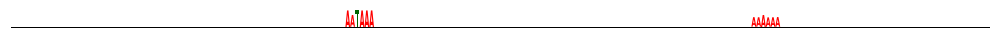

In [6]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [7]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.656512169581631


In [8]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.8729655119119495


In [9]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [10]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [11]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='softplus', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    onehot_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_onehot_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] / K.maximum(K.tile(x[0], (1, 1, 1, 4)), K.epsilon()), name='scrambler_logit_scale')
    
    def _scrambler_func(sequence_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        #Scale logits by importance scores
        scaled_logits = scale_logits([final_conv_out, onehot_to_logits(sequence_input)])
        
        return scaled_logits, final_conv_out

    return _scrambler_func


In [12]:
#Keras loss functions

def get_sigmoid_nll() :

    def _sigmoid_nll(y_true, y_pred) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return -K.mean(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1)
    
    return _sigmoid_nll

def get_kl_divergence() :

    def _kl_divergence(y_true, y_pred) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        
        left_mean_kl = K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
        right_mean_kl = K.mean(y_pred * K.log(y_pred / y_true) + (1.0 - y_pred) * K.log((1.0 - y_pred) / (1.0 - y_true)), axis=-1)

        return -(left_mean_kl + right_mean_kl)
    
    return _kl_divergence

def get_min_nll() :

    def _min_nll(y_pred) :

        y_pred = K.clip(y_pred, 0.0, 1.0 - K.epsilon())
        
        return K.mean(-K.log(1.0 - y_pred), axis=-1)
    
    return _min_nll

def get_margin_entropy_ame_masked(pwm_start, pwm_end, pwm_background, max_bits=1.0) :
    
    def _margin_entropy_ame_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits, shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(pwm_start, pwm_end, pwm_background, target_bits=1.0) :
    
    def _target_entropy_sme_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        return (mean_conservation - target_bits)**2
    
    return _target_entropy_sme_masked

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [13]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 205
n_samples = 32
sample_mode = 'st'
#sample_mode = 'gumbel'

#Resnet parameters
resnet_n_groups = 1
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 8
resnet_dilation_rates = [1]
resnet_drop_rate = 0.25

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate
)

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [14]:
#Load Predictor
predictor_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(1, seq_length, 4), name='scrambler_input')

scrambled_logits, importance_scores = scrambler(scrambler_input)

pwm_logits, pwm, sampled_pwm, _, _ = sampler(scrambler_class, scrambled_logits)

scrambler_model = Model([scrambler_input, scrambler_class], [pwm_logits, pwm, sampled_pwm, importance_scores])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [16]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(1, seq_length, 4), name='ae_scrambler_input')

#APARENT-specific tensors
aparent_lib = Input(shape=(13,), name='aparent_lib_input')
aparent_distal_pas = Input(shape=(1,), name='aparent_distal_pas_input')

#Run encoder and decoder
_, scrambled_pwm, scrambled_sample, pwm_mask, _ = sampler(ae_scrambler_class, scrambler(ae_scrambler_input)[0])

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, 1, seq_length, 4)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)

def _make_prediction(inputs, predictor=predictor) :
    pred_seq_in, pred_lib_in, pred_distal_pas_in = inputs
    
    pred_seq_in_perm = K.expand_dims(pred_seq_in[:, 0, ...], axis=-1)
    
    return predictor([pred_seq_in_perm, pred_lib_in, pred_distal_pas_in])[0]

def _make_prediction_scrambled(inputs, predictor=predictor, n_samples=n_samples) :
    pred_seq_in, pred_lib_in, pred_distal_pas_in = inputs
    
    pred_seq_in_perm = K.expand_dims(pred_seq_in[:, 0, ...], axis=-1)
    
    return predictor([pred_seq_in_perm, K.tile(pred_lib_in, (n_samples, 1)), K.tile(pred_distal_pas_in, (n_samples, 1))])[0]

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = Lambda(_make_prediction, name='make_prediction_non_scrambled')([ae_scrambler_input, aparent_lib, aparent_distal_pas])

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = Lambda(_make_prediction_scrambled, name='make_prediction_scrambled')([scrambled_sample_deflated, aparent_lib, aparent_distal_pas])

#Define layer to inflate sample axis
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#Cost function parameters
pwm_start = 10
pwm_end = 201
target_bits = 1.5

#NLL cost
nll_loss_func = get_min_nll()

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=1.8)

#Entropy cost
entropy_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=target_bits)
#entropy_loss_func = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, max_bits=target_bits)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x), name='nll')(y_pred_scrambled)

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([scrambled_pwm, pwm_mask])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([scrambled_pwm, pwm_mask])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, aparent_lib, aparent_distal_pas],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, [sequence_template], [x_mean_logits])

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=10.0)
    }
)


In [17]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 1, 205, 32)   160         scrambler_input[0][0]            
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 1, 205, 32)   128         scrambler_conv_0[0][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 205, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

In [18]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 1, 205, 32)   160         ae_scrambler_input[0][0]         
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 1, 205, 32)   128         scrambler_conv_0[1][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 205, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

In [19]:
#Training configuration

#Define number of training epochs
n_epochs = 50

#Define experiment suffix (optional)
experiment_suffix = "_only_negative_features"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_sample_mode_" + sample_mode + "_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_bits_" + str(target_bits).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_apa_doubledope_inverted_scores_sample_mode_st_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_15_only_negative_features


In [20]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

aparent_l_train = np.zeros((x_train.shape[0], 13))
aparent_l_train[:, 4] = 1.
aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_train = np.ones((x_train.shape[0], 1))
aparent_d_test = np.ones((x_test.shape[0], 1))

# train the autoencoder
train_history = loss_model.fit(
    [s_train, x_train, aparent_l_train, aparent_d_train],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test, aparent_l_test, aparent_d_test],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 31264 samples, validate on 1728 samples
Epoch 1/50
31264/31264 [==============================] - 52s 2ms/step - loss: 0.1621 - nll_loss: 0.1049 - conservation_loss: 0.0572 - entropy_loss: 0.0000e+00 - val_loss: 0.1134 - val_nll_loss: 0.0913 - val_conservation_loss: 0.0221 - val_entropy_loss: 0.0000e+00
Epoch 2/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0871 - nll_loss: 0.0550 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0321 - val_loss: 0.0752 - val_nll_loss: 0.0477 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0275
Epoch 3/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0784 - nll_loss: 0.0533 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0251 - val_loss: 0.0708 - val_nll_loss: 0.0451 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0257
Epoch 4/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0743 - nll_loss: 0.0521 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0

Epoch 32/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0551 - nll_loss: 0.0390 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0160 - val_loss: 0.0540 - val_nll_loss: 0.0322 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0218
Epoch 33/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0548 - nll_loss: 0.0389 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0159 - val_loss: 0.0535 - val_nll_loss: 0.0330 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0205
Epoch 34/50
31264/31264 [==============================] - 44s 1ms/step - loss: 0.0547 - nll_loss: 0.0386 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0161 - val_loss: 0.0559 - val_nll_loss: 0.0325 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0234
Epoch 35/50
31264/31264 [==============================] - 45s 1ms/step - loss: 0.0542 - nll_loss: 0.0387 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0156 - val_loss: 0.0491 - val_nll_loss: 0.0331

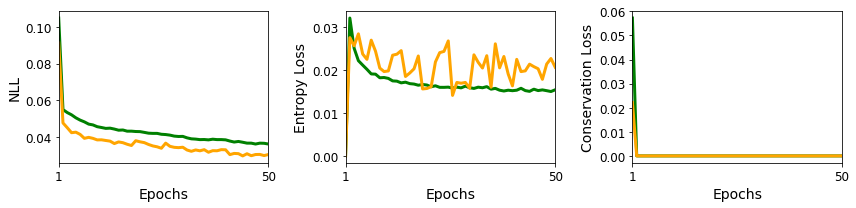

In [21]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [22]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_apa_doubledope_inverted_scores_sample_mode_st_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_15_only_negative_features.h5 


In [23]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects={
    'st_sampled_softmax' : st_sampled_softmax
})

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_apa_doubledope_inverted_scores_sample_mode_st_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_15_only_negative_features.h5 


In [20]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model.load_weights(model_path, by_name=True)

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_apa_doubledope_inverted_scores_sample_mode_st_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_15_only_negative_features.h5 


Test sequence 0:
 - Prediction (original) = 0.09
 - Predictions (scrambled) = [0.0, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01]


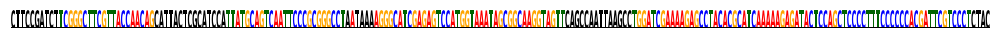

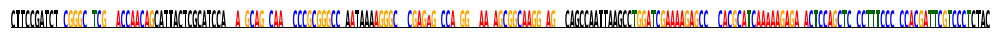

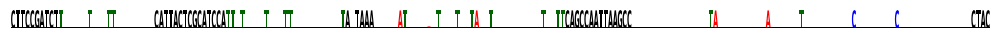

Test sequence 1:
 - Prediction (original) = 0.18
 - Predictions (scrambled) = [0.04, 0.03, 0.01, 0.03, 0.03, 0.01, 0.01, 0.04, 0.05, 0.04]


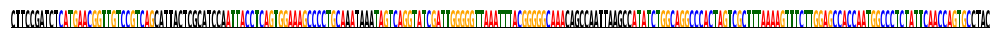

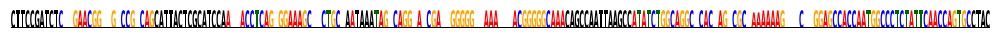

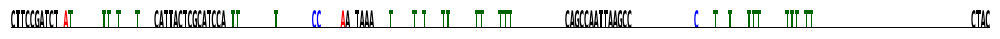

Test sequence 2:
 - Prediction (original) = 0.78
 - Predictions (scrambled) = [0.01, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.05, 0.03, 0.02]


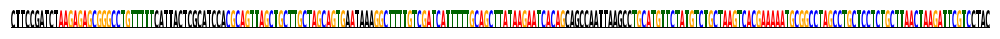

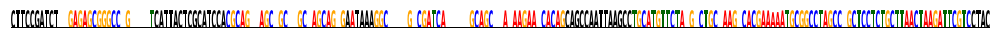

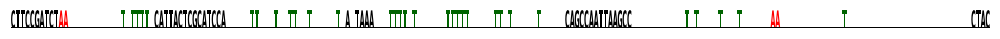

Test sequence 3:
 - Prediction (original) = 0.15
 - Predictions (scrambled) = [0.04, 0.01, 0.0, 0.03, 0.01, 0.01, 0.0, 0.01, 0.01, 0.0]


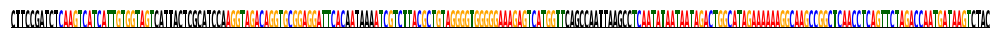

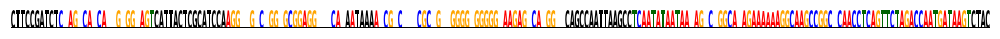

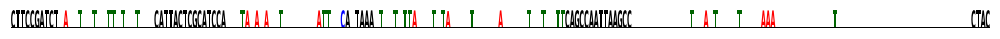

Test sequence 4:
 - Prediction (original) = 0.27
 - Predictions (scrambled) = [0.03, 0.01, 0.03, 0.0, 0.01, 0.01, 0.0, 0.01, 0.01, 0.02]


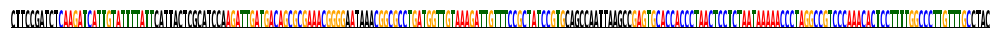

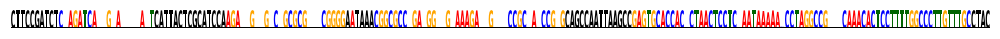

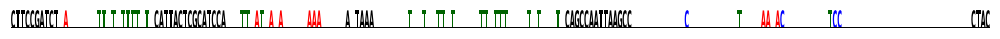

Test sequence 5:
 - Prediction (original) = 0.67
 - Predictions (scrambled) = [0.02, 0.0, 0.03, 0.0, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01]


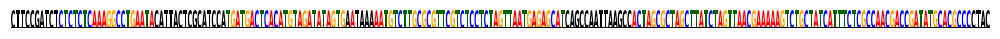

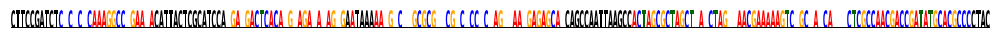

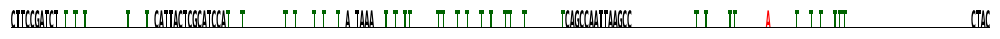

Test sequence 6:
 - Prediction (original) = 0.93
 - Predictions (scrambled) = [0.05, 0.07, 0.01, 0.37, 0.08, 0.1, 0.08, 0.03, 0.03, 0.03]


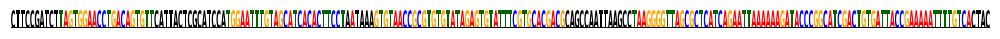

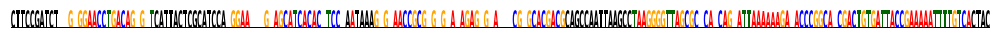

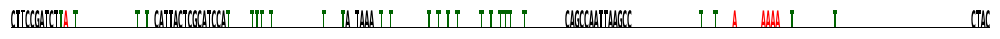

Test sequence 7:
 - Prediction (original) = 0.84
 - Predictions (scrambled) = [0.08, 0.08, 0.11, 0.04, 0.22, 0.06, 0.06, 0.02, 0.03, 0.02]


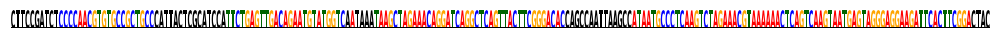

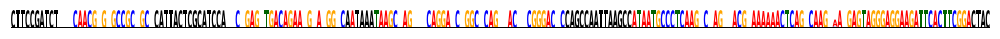

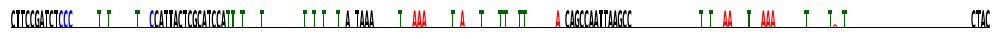

Test sequence 8:
 - Prediction (original) = 0.6
 - Predictions (scrambled) = [0.02, 0.01, 0.0, 0.01, 0.01, 0.03, 0.01, 0.01, 0.02, 0.01]


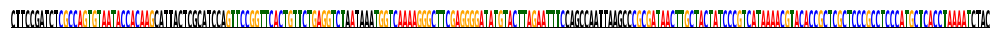

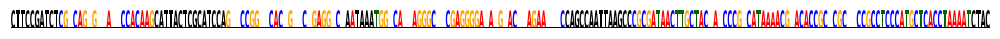

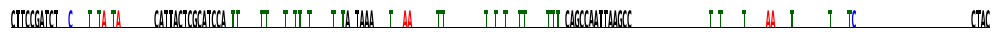

Test sequence 9:
 - Prediction (original) = 0.65
 - Predictions (scrambled) = [0.03, 0.01, 0.06, 0.06, 0.05, 0.02, 0.13, 0.05, 0.08, 0.06]


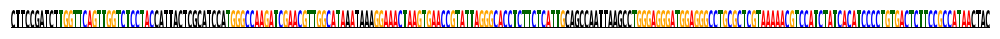

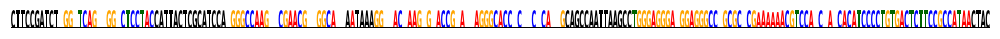

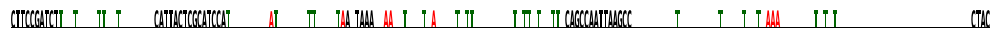

In [21]:
#Visualize a few reconstructed sequence patterns

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

save_examples = [2, 3, 4, 5, 6, 7]

s_test = np.zeros((x_test.shape[0], 1))

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

_, pwm_test, sample_test, importance_scores = scrambler_model.predict_on_batch(x=[x_test[:32], s_test[:32]])

subtracted_logits_test = (2. * np.array(x_test[:32], dtype=np.float64) - 1.) * np.maximum(np.array(importance_scores, dtype=np.float64), 1e-7)
subtracted_pwm_test = np.exp(subtracted_logits_test) / np.expand_dims(np.sum(np.exp(subtracted_logits_test), axis=-1), axis=-1)

for plot_i in range(0, 10) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(np.expand_dims(x_test[plot_i, 0, :, :], axis=0), axis=-1), aparent_l_test[:1], aparent_d_test[:1]], batch_size=1)[0][0, 0]
    y_test_hat = predictor.predict(x=[np.expand_dims(sample_test[plot_i, :, 0, :, :], axis=-1), aparent_l_test[:32], aparent_d_test[:32]], batch_size=32)[0][:10, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and plot_i in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_original_test_ix_" + str(plot_i))
    plot_dna_logo(pwm_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(plot_i))
    plot_dna_logo(subtracted_pwm_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_subtracted_test_ix_" + str(plot_i))


In [22]:
#Visualize a few reconstructed images

s_test = np.zeros((x_test.shape[0], 1))

_, pwm_test, sample_test, importance_scores_test = scrambler_model.predict(x=[x_test, s_test], batch_size=32, verbose=True)


1728/1728 [==============================] - 2s 963us/step


In [26]:
#Save predicted importance scores

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [23]:
#Calculate original and scrambled predictions

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

y_test_hats = []
y_test_hats_scrambled = []
for i in range(x_test.shape[0]) :
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(np.expand_dims(x_test[i, 0, :, :], axis=0), axis=-1), aparent_l_test[:1], aparent_d_test[:1]], batch_size=1)[0][0, 0]
    y_test_hat = np.mean(predictor.predict(x=[np.expand_dims(sample_test[i, :, 0, :, :], axis=-1), aparent_l_test[:32], aparent_d_test[:32]], batch_size=32)[0][:, 0])
    
    y_test_hats.append(y_test_hat_ref)
    y_test_hats_scrambled.append(y_test_hat)

y_test_hat = np.array(y_test_hats)
y_test_hat_scrambled = np.array(y_test_hats_scrambled)


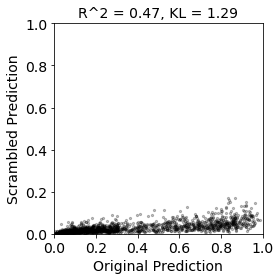

In [24]:
from scipy.stats import pearsonr

save_figs = True

r_val, _ = pearsonr(y_test_hat, y_test_hat_scrambled)

left_kl_divs = y_test_hat * np.log(y_test_hat / y_test_hat_scrambled) + (1. - y_test_hat) * np.log((1. - y_test_hat) / (1. - y_test_hat_scrambled))
right_kl_divs = y_test_hat_scrambled * np.log(y_test_hat_scrambled / y_test_hat) + (1. - y_test_hat_scrambled) * np.log((1. - y_test_hat_scrambled) / (1. - y_test_hat))

mean_kl_div = np.mean(left_kl_divs + right_kl_divs)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test_hat_scrambled, color='black', s=5, alpha=0.25)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)

plt.xlabel("Original Prediction", fontsize=14)
plt.ylabel("Scrambled Prediction", fontsize=14)

plt.title("R^2 = " + str(round(r_val**2, 2)) + ", KL = " + str(round(mean_kl_div, 2)), fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_test_scatter.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_test_scatter.eps")

plt.show()
